In [34]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from numpy import mean
from sklearn import svm as svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

from sklearn.utils import resample
random.seed(123)

# import xgboost as xgb
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', 500)

In [3]:
# read csv file
df = pd.read_csv('T2.csv', low_memory=False)

In [4]:
print("Sample Size:", df.shape[0])
print("# of predictors:", df.shape[1])

Sample Size: 22992
# of predictors: 318


In [5]:
# Required Variables, Features, and Label

req_vars = ['SwellOneExit', 'YearsAsCoach', 'DaysTSubmitNoMissing',
       'FitNoMissing', 'RelationshipBuildingNoMissing',
       'FinalAchievementNoMissing', 'CommAndPresNoMissing',
       'PredModelScoreNoMissing', 'CMProspectRatingNoMissing',
       'AgeAtFDOSNoMissing', 'SchoolSelectivityNoMissing',
       'CumuGPANoMissing', 'PerseveranceNoMissing', 'FRPLNoMissing',
       'YearsSchoolPartnerNoMissing', 'YearsPartnerPartnerNoMissing',
       'FirstYearsInSchoolNoMissing', 'SecondYearsInSchoolNoMissing',
       'CMsInSchoolNoMissing', 'CertProgramCostNoMissing',
       'AvgFirstMonthSalNoMissing', 'RentPropNoMissing',
       'AvgRentNoMissing', 'CorpsSizeNoMissing', 'RegPrefLevNoMissing',
       'CSI6NoMissing', 'CSI5NoMissing', 'CSI3NoMissing',
       'CSI12NoMissing', 'CLI8NoMissing', 'CLI6NoMissing',
       'OtherCMsSameCoachNoMissing', 'OtherCMsPrevCoachNoMissing',
       'K12TeachNo', 'K12TeachYes', 'K12TeachNull', 'HadFamRespNo',
       'HadFamRespYes', 'HadFamRespNull', 'PellGrantNoOrMissing',
       'PellGrantYes', 'GenderFemale', 'GenderMale', 'CalcGradStudent',
       'CalcJunior', 'CalcProfessional', 'CalcUndergrad', 'CalcUnknown',
       'AttendLIC_HS_No', 'AttendLIC_HS_Yes', 'AttendLIC_HS_Unknown',
       'GrewUpLIC_No_Or_Unknown', 'GrewUpLIC_Yes',
       'LIC_Served_No_Or_Unknown', 'LIC_Served_Yes', 'Eth_Black',
       'Eth_Native', 'Eth_AsianAmPacIsl', 'Eth_Latinx',
       'Eth_MultiEthMultiRacial', 'Eth_OtherOrUnknown', 'Eth_White',
       'VarsitySport_No_Or_Unknown', 'VarsitySport_Yes',
       'DeferralRequested', 'DeferralNotRequested', 'Title1No',
       'Title1Yes', 'Grade_ECE', 'Grade_HIGH', 'Grade_LOWELEM',
       'Grade_MIDDLE', 'Grade_UPPERELEM', 'Grade_Unknown',
       'School_Charter', 'School_Public', 'School_Other', 'LGB_NoProtect',
       'LGB_LocalProtect', 'LGB_StateProtect', 'TeacherPP_No',
       'TeacherPP_Yes', 'Region_Large', 'Region_Medium', 'Region_Small',
       'Urbanicity_Both', 'Urbanicity_Rural', 'Urbanicity_Urban',
       'COL_High', 'COL_Low', 'COL_Medium', 'MajorTeaching_Match',
       'MajorTeaching_Mismatch', 'MajorOffered_Match',
       'MajorOffered_Mismatch']

df = df[req_vars] # updating the dataframe
Y = df['SwellOneExit']
X = df.drop('SwellOneExit', axis=1)

In [7]:
# training test split

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size = 0.2, random_state=123)

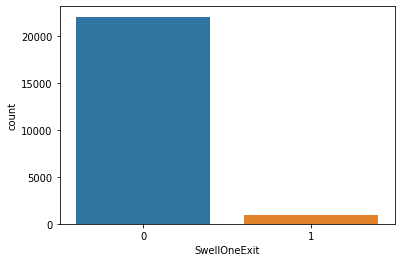

In [8]:
# baseline
y = df['SwellOneExit']

hst = sns.countplot(x = y, data = df)

In [9]:
#Oversampling the minority class 
df_ovsmpl = pd.concat([train_features, train_labels], axis=1)


df_majority = df_ovsmpl[df_ovsmpl.SwellOneExit==0]
df_minority = df_ovsmpl[df_ovsmpl.SwellOneExit==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.SwellOneExit.value_counts()

1    17662
0    17662
Name: SwellOneExit, dtype: int64

In [10]:
upsmpl_Y = df_upsampled['SwellOneExit']
upsmpl_X = df_upsampled.drop('SwellOneExit', axis=1)

# training test split of the oversampled dataframe

upsmpl_train_features, upsmpl_test_features, upsmpl_train_labels, upsmpl_test_labels = train_test_split(upsmpl_X, upsmpl_Y, test_size = 0.2, random_state=123)



In [11]:
# random forest 
rf_upsampled = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs=-1)

# train model
rf_upsampled_mdl = rf_upsampled.fit(upsmpl_train_features, upsmpl_train_labels)

# test model
rf_upsampled_pred = rf_upsampled_mdl.predict(test_features)

rf_acc_score = accuracy_score(test_labels, rf_upsampled_pred)
rf_prec_score = precision_score(test_labels, rf_upsampled_pred, average='weighted')
rf_rec_score = recall_score(test_labels, rf_upsampled_pred)
rf_roc_auc = roc_auc_score(test_labels, rf_upsampled_pred)
rf_f1_score = f1_score(test_labels, rf_upsampled_pred)

print("Accuracy:", rf_acc_score, "\n", "Precision: ", rf_prec_score, "\n", "Recall:", rf_rec_score, "\n", "F1 score:", rf_f1_score, "\n", "ROC-AUC:", rf_roc_auc)

Accuracy: 0.9639051967819091 
 Precision:  0.9295249331298358 
 Recall: 0.0 
 F1 score: 0.0 
 ROC-AUC: 0.4998872350022553


In [12]:
# logistic regression
lr_upsampled = LogisticRegression(solver='liblinear')

# train model
lr_upsampled_mdl = lr_upsampled.fit(upsmpl_train_features, upsmpl_train_labels)

# test model
lr_upsampled_pred = lr_upsampled_mdl.predict(test_features)

lr_acc_score = accuracy_score(test_labels, lr_upsampled_pred)
lr_prec_score = precision_score(test_labels, lr_upsampled_pred, average='weighted')
lr_rec_score = recall_score(test_labels, lr_upsampled_pred)
lr_roc_auc = roc_auc_score(test_labels, lr_upsampled_pred)
lr_f1_score = f1_score(test_labels, lr_upsampled_pred)

print("Accuracy:", lr_acc_score, "\n", "Precision: ", lr_prec_score, "\n", "Recall:", lr_rec_score, "\n", "F1 score:", lr_f1_score, "\n", "ROC-AUC:", lr_roc_auc)

Accuracy: 0.6366601435094585 
 Precision:  0.9405497622840358 
 Recall: 0.5333333333333333 
 F1 score: 0.09528965890633459 
 ROC-AUC: 0.5869192602616148


In [13]:
#support vector machine
svm_upsampled = svm.SVC()

# train model
svm_upsampled_mdl = svm_upsampled.fit(upsmpl_train_features, upsmpl_train_labels)

# test model
svm_upsampled_mdl_pred = lr_upsampled_mdl.predict(test_features)


In [15]:
svm_acc_score = accuracy_score(test_labels, svm_upsampled_mdl_pred)
svm_prec_score = precision_score(test_labels, svm_upsampled_mdl_pred, average='weighted')
svm_rec_score = recall_score(test_labels, svm_upsampled_mdl_pred)
svm_roc_auc = roc_auc_score(test_labels, svm_upsampled_mdl_pred)
svm_f1_score = f1_score(test_labels, svm_upsampled_mdl_pred)

print("Accuracy:", svm_acc_score, "\n", "Precision: ", svm_prec_score, "\n", "Recall:", svm_rec_score, "\n", "F1 score:", svm_f1_score, "\n", "ROC-AUC:", svm_roc_auc)

Accuracy: 0.6366601435094585 
 Precision:  0.9405497622840358 
 Recall: 0.5333333333333333 
 F1 score: 0.09528965890633459 
 ROC-AUC: 0.5869192602616148


In [34]:
label = df_upsampled['SwellOneExit']
features = df_upsampled.drop('SwellOneExit', axis=1)

# training test split

train_features, test_features, train_labels, test_labels = train_test_split(features, label, test_size = 0.2, stratify=label)


In [16]:
#Undersampling the majority class 
df_undsmpl = pd.concat([train_features, train_labels], axis=1)


df_undsmpl_majority = df_undsmpl[df_undsmpl.SwellOneExit==0]
df_undsmpl_minority = df_undsmpl[df_undsmpl.SwellOneExit==1]

# Upsample minority class
df_majority_undsampled = resample(df_undsmpl_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=len(df_undsmpl_minority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_undsampled = pd.concat([df_majority_undsampled, df_undsmpl_minority])
 
# Display new class counts
df_undsampled.SwellOneExit.value_counts()

1    731
0    731
Name: SwellOneExit, dtype: int64

In [17]:
undsmpl_Y = df_undsampled['SwellOneExit']
undsmpl_X = df_undsampled.drop('SwellOneExit', axis=1)

# training test split of the undersampled dataframe

undsmpl_train_features, undsmpl_test_features, undsmpl_train_labels, undsmpl_test_labels = train_test_split(undsmpl_X, undsmpl_Y, test_size = 0.2, random_state=123)



In [18]:
# random forest 
rf_downsampled = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs=-1)

# train model
rf_downsampled_mdl = rf_downsampled.fit(undsmpl_train_features, undsmpl_train_labels)

# test model
rf_downsampled_pred = rf_downsampled_mdl.predict(test_features)

rf_dwnsmpl_acc_score = accuracy_score(test_labels, rf_downsampled_pred)
rf_dwnsmpl_rec_score = recall_score(test_labels, rf_downsampled_pred)
rf_dwnsmpl_roc_auc = roc_auc_score(test_labels, rf_downsampled_pred)
rf_dwnsmpl_prec_score = precision_score(test_labels, rf_downsampled_pred, average='weighted')
rf_dwnsmpl_f1_score = f1_score(test_labels, rf_downsampled_pred)

print("Accuracy:", rf_dwnsmpl_acc_score, "\n", "Precision: ", rf_dwnsmpl_prec_score, "\n", "Recall:", rf_dwnsmpl_rec_score, "\n", "F1 score:", rf_dwnsmpl_f1_score, "\n", "ROC-AUC:", rf_dwnsmpl_roc_auc)


Accuracy: 0.6103500761035008 
 Precision:  0.9420864456137802 
 Recall: 0.5818181818181818 
 F1 score: 0.09677419354838711 
 ROC-AUC: 0.5966149997949727


In [20]:
# logistic regression
lr_undsampled = LogisticRegression(solver='liblinear')

# train model
lr_undsampled_mdl = lr_undsampled.fit(undsmpl_train_features, undsmpl_train_labels)

# test model
lr_undsampled_pred = lr_undsampled_mdl.predict(test_features)

lr_dwnsmpl_acc_score = accuracy_score(test_labels, lr_undsampled_pred)
lr_dwnsmpl_prec_score = precision_score(test_labels, lr_undsampled_pred, average='weighted')
lr_dwnsmpl_rec_score = recall_score(test_labels, lr_undsampled_pred)
lr_dwnsmpl_roc_auc = roc_auc_score(test_labels, lr_undsampled_pred)
lr_dwnsmpl_f1_score = f1_score(test_labels, lr_undsampled_pred)

print("Accuracy:", lr_dwnsmpl_acc_score, "\n", "Precision: ", lr_dwnsmpl_prec_score, "\n", "Recall:", lr_dwnsmpl_rec_score, "\n", "F1 score:", lr_dwnsmpl_f1_score, "\n", "ROC-AUC:", lr_dwnsmpl_roc_auc)


Accuracy: 0.5992607088497499 
 Precision:  0.942293792646171 
 Recall: 0.593939393939394 
 F1 score: 0.09612555174104953 
 ROC-AUC: 0.5966990609751097


In [22]:
#support vector machine
svm_undsampled = svm.SVC()

# train model
svm_undsampled_mdl = svm_undsampled.fit(undsmpl_train_features, undsmpl_train_labels)

# test model
svm_undsampled_mdl_pred = svm_undsampled_mdl.predict(test_features)

svm_acc_score = accuracy_score(test_labels, svm_undsampled_mdl_pred)
svm_prec_score = precision_score(test_labels, svm_undsampled_mdl_pred, average='weighted')
svm_rec_score = recall_score(test_labels, svm_undsampled_mdl_pred)
svm_roc_auc = roc_auc_score(test_labels, svm_undsampled_mdl_pred)
svm_f1_score = f1_score(test_labels, svm_undsampled_mdl_pred)

print("Accuracy:", svm_acc_score, "\n", "Precision: ", svm_prec_score, "\n", "Recall:", svm_rec_score, "\n", "F1 score:", svm_f1_score, "\n", "ROC-AUC:", svm_roc_auc)


Accuracy: 0.4511850402261361 
 Precision:  0.9366335209087439 
 Recall: 0.6303030303030303 
 F1 score: 0.0761346998535871 
 ROC-AUC: 0.537411325706319


In [35]:
#Oversampling the minority class 
df_ovsmpl = pd.concat([train_features, train_labels], axis=1)

df_ovsmpl.shape

sm_y = df_ovsmpl.SwellOneExit
sm_x = df_ovsmpl.drop('SwellOneExit', axis=1)

X_train, X_test, y_train, y_test = train_test_split(sm_x, sm_y, test_size=0.2, random_state=123)

sm = SMOTE(random_state=123, ratio=27.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

TypeError: __init__() got an unexpected keyword argument 'ratio'

In [29]:
df_ovsmpl.SwellOneExit.value_counts()

0    17662
1      731
Name: SwellOneExit, dtype: int64

In [ ]:
outliers = ['DaysTSubmitNoMissing', 'AgeAtFDOSNoMissing', 'FirstYearsInSchoolNoMissing', 'SecondYearsInSchoolNoMissing',
            'CMsInSchoolNoMissing', 'CertProgramCostNoMissing', 'CorpsSizeNoMissing', 'OtherCMsSameCoachNoMissing',
            'OtherCMsPrevCoachNoMissing']

In [11]:
import matplotlib as mpl 

import matplotlib.pyplot as plt 

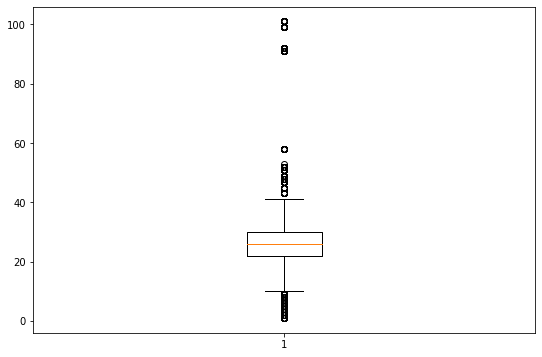

In [22]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
# outliers_df = df[outliers]
bp = ax.boxplot(df['OtherCMsSameCoachNoMissing'])

# Save the figure
# fig.savefig('fig1.png', bbox_inches='tight')